In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
file_path = "../data/raw/excel1.csv"
df = pd.read_csv(file_path, sep=',')

# Convertir la columna ID_Date a formato de fecha (YYYY-MM-DD)
df['ID_Date'] = pd.to_datetime(df['ID_Date'], format='%Y%m').dt.strftime('%Y-%m-%d')
# Mostrar el DataFrame
df.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
0,2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
1,2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2,2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
3,2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
4,2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


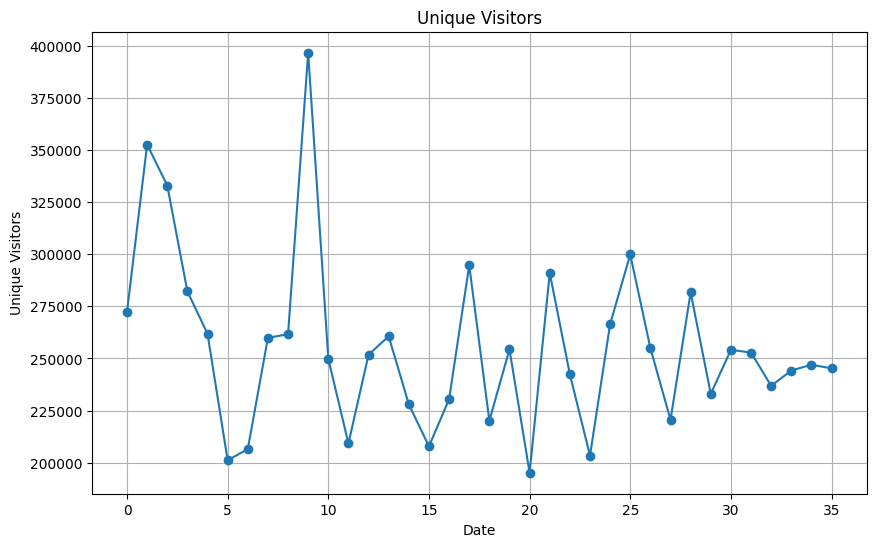

In [38]:
# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Unique_visitors'], marker='o', linestyle='-')
plt.title('Unique Visitors')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.grid(True)
plt.show()

In [39]:
import numpy as np
print(np.__version__)

1.23.5


In [40]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ajustar el modelo SARIMA automáticamente
import pandas as pd
from pmdarima import auto_arima


c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=573.877, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=576.683, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=570.520, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=575.776, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=575.922, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=566.423, Time=0.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=566.919, Time=0.08 sec


c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[12]             : AIC=568.711, Time=0.12 sec


c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=569.020, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=567.949, Time=0.14 sec


c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=569.961, Time=0.45 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=568.597, Time=0.15 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit time: 1.555 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -279.211
Date:                            Thu, 03 Apr 2025   AIC                            566.423
Time:                                    01:14:01   BIC                            570.965
Sample:                                         0   HQIC                           567.565
                                             - 36                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0

c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


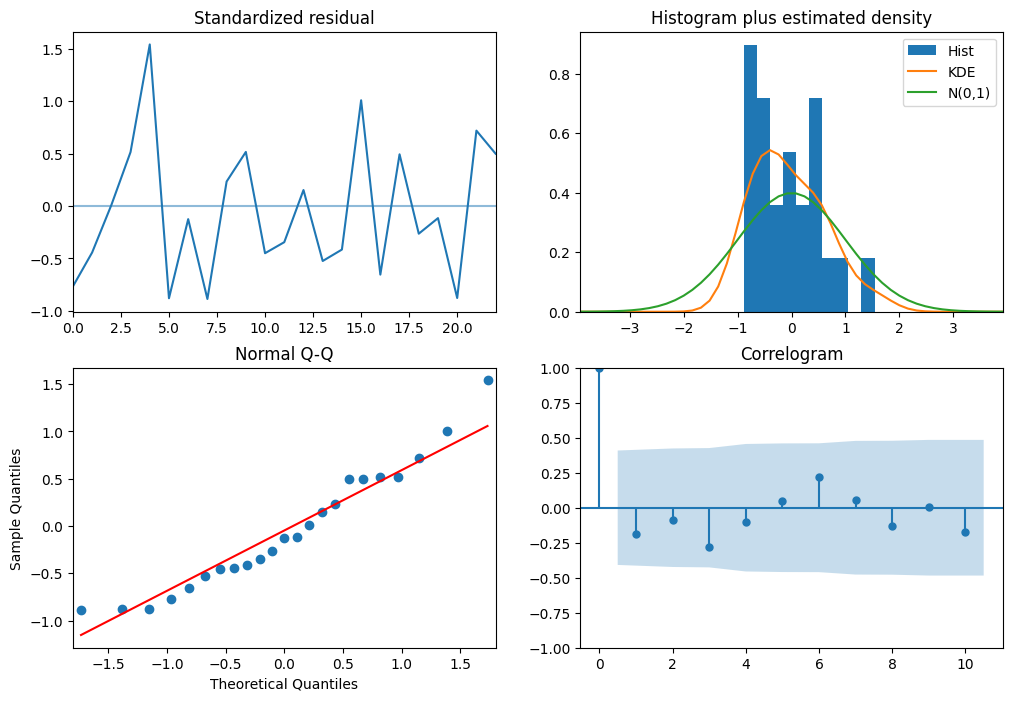

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 1. Preprocesamiento
y = np.log1p(df["Unique_visitors"])  # Transformación logarítmica
X = df[['SocialNetworks', 'PaidSearch']]  # Variables exógenas clave


# Dividir en train y test (80%-20%)
train_size = int(len(df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]

scaler = StandardScaler()

# 3. Escalado (solo con datos de train para evitar data leakage)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),
                           columns=X.columns, 
                           index=X.index)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                           columns=X_train.columns, 
                           index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                          columns=X_test.columns, 
                          index=X_test.index)


# 2. Búsqueda del modelo óptimo
model = auto_arima(
    y,
    exogenous=X_scaled,  # Opcional: eliminar si no hay relación clara
    seasonal=True,
    m=12,
    d=1,                  # Diferenciación no estacional fija
    D=1,                  # Diferenciación estacional fija
    start_q=1, max_q=1,   # Solo MA(1)
    start_Q=0, max_Q=0,   # Sin MA estacional
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)

# 3. Predicción
preds_log = model.predict(n_periods=12, exogenous=X_scaled)
preds = np.expm1(preds_log)  # Revertir transformación

# 3. Validación
print(model.summary())

# Gráficos de diagnóstico
model.plot_diagnostics(figsize=(12, 8))
plt.show()



c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=371.857, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.300, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=370.964, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=373.877, Time=0.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=373.671, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=371.733, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=368.040, Time=0.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=370.067, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=373.534, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=371.388, Time=0.03 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 0.478 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(

c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josit\TERCER CURSO\IA\IA-Casos\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


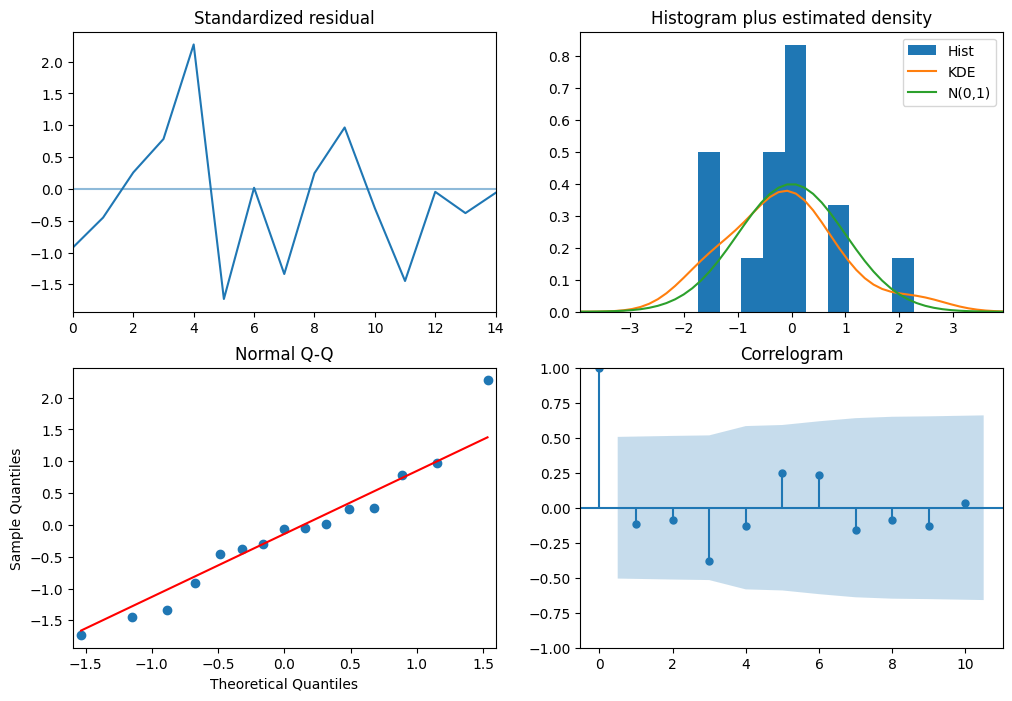

In [ ]:
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preprocesamiento sin transformación logarítmica
y = df["Unique_visitors"]  # Usamos los valores originales
X = df[['SocialNetworks', 'PaidSearch']]  # Variables exógenas clave

# 2. División train-test (80%-20%)
train_size = int(len(df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

# 3. Escalado (solo con train)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                   columns=X_train.columns, 
                   index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                  columns=X_test.columns,
                  index=X_test.index)

# 4. Búsqueda del modelo (sin log)
model = auto_arima(
    y_train,  # Usamos y_train original
    exogenous=X_train_scaled,
    seasonal=True,
    m=12,
    d=1,
    D=1,
    start_p=0, max_p=1,
    start_q=0, max_q=1,
    start_Q=0, max_Q=0,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)

# 5. Predicción (directamente en escala original)
preds = model.predict(n_periods=12, exogenous=X_test_scaled)

# 6. Resultados
print(model.summary())


# Diagnóstico
model.plot_diagnostics(figsize=(12,8))
plt.show()